## Resposta em frequência e margens de estabilidade de um sistema SISO

As **características da resposta em malha fechada** de um sistema SISO podem ser inferidas **a partir da análise da função de transferência em malha aberta**: 
$$L(s) = G(s) H(s) = K \frac{N(s)}{D(s)}$$
com:
*  $G(s)$ sendo a função de transferência equivalente ao canal direto;
*  $H(s)$ sendo a função de transferência equivalente ao canal de realimentação. 

Em particular, sabemos que a função de transferência em **malha fechada** é dada por: 
$$T(s) = \frac{G(s)}{1 + L(s)}$$

Assim, a condição necessária para que um valor de $s \in \mathbb{C}$ seja um **polo do sistema em malha fechada** é necessário que:
$$
1 + L(s) = 0 \quad \Rightarrow \quad 
|L(s)| = 1
\quad \text{e} \quad
\phase{L(s)} \equiv 180^\circ
$$

A análise da condição $\phase{L(s)} \equiv 180^\circ$ leva à construção do **lugar das raízes**. 

Veremos agora como a análise da resposta em frequência $L(\mathsf{j} \omega)$ para $\omega \geq 0$ pode nos fornecer informações acerca da resposta do sistema em malha fechada, podendo assim ser usada como critério de projeto de compensadores.

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib widget
import control as ct
import sympy as sp

import ipywidgets as widgets
from ipywidgets import interactive

from scipy.interpolate import interp1d
from perlin_noise import PerlinNoise
from scipy.optimize import minimize
from tbcontrol.symbolic import routh
from sympy.solvers import solve

s = ct.tf([1, 0], [1])

In [2]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

### 1. Visualizando $L(s)$ como uma função $\mathbb{C} \to \mathbb{C}$



In [3]:
#Parâmetros:
Bb = 2.5 #Boca [m]
Db = 0.4 #Calado [m]
LOA = 8.4 #Comprimento fora-a-fora do barco [m]
Hb = 1.7 #Altura do barco [m]
Me = 10.0 #Massa do eixo do giroscópio [kg]
Md = 160.0 #Massa do disco do giroscópio [kg]
le = 0.5 #Comprimento do eixo do giroscópio [m]
re = 0.09 #Raio do eixo do giroscópio [m]
rd = 0.230 #Raio do disco do giroscópio [m]
ed = 0.150 #Espessura do disco do giroscópio [m]
g = 9.81 #Aceleração da gravidade [m/s²]
rho_w = 997.0 #Massa específica da água a 25°C [kg/m³]
wf_base = 1.40071 #freq. de exitação das ondas [rad/s]
A0_base = 2.0 #Altura das ondas [m]
Cg = 500 #Momento de restituição do giroscópio [N.m]
Bg = 250.0 #Coef. de dissipação por atrito do giroscópio [N.m.s]

c2 = 0.006 #Coef. adim. da dissipação por irradiação de ondas
c3 = 0.149 #Coef. adim. de massa adicional da embarcação

In [4]:
Omega = sp.symbols('Ω')

#Componentes da matriz A:
a_31 = - g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3) + LOA*Hb**2))
a_33 = - 12*np.sqrt(2)*(g**2)*((Bb/g)**(3/2))*c2/((Bb**2)*(LOA+12*c3)+LOA*Hb**2)
a_34 = - 6*Omega*Md*(rd**2)/(Bb*Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2)*rho_w)
a_42 = -12*Cg/((ed**2)*(Md-Me)+3*Md*(rd**2)+Me*((le**2)+3*(re**2)))
a_43 = Omega*(-1 + (12*Md*rd**2)/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2)))
a_44 = -12*Bg/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2))

#Matriz A:
A = sp.Matrix([[0,0,1,0],[0,0,0,1],[a_31,0,a_33,a_34],[0,a_42,a_43,a_44]])

#Componentes da matriz B:
I_Gy = (1/12)*Me*(3*re**2 + le**2 - ed**2) + (1/12)*Md*(3*rd**2 + ed**2) #Momento de Inércia do Giroscópio em relação ao eixo y móvel

#Matriz B:
B = sp.Matrix([[0],[0],[0],[(1/I_Gy)]])

#Componentes da matriz E:
e_3 = g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2))

#Matriz E:
E = sp.Matrix([[0],[0],[e_3],[0]])

#Matriz C observando somente o ângulo de roll:
C_φ = sp.Matrix([[1, 0, 0, 0]])

#Matriz D:
D = sp.Matrix([[0]])

In [5]:
An = sp.lambdify((Omega), A)
Bn = sp.lambdify((),B)
En = sp.lambdify((),E)

In [6]:
#Espaço de Estados de malha aberta com Ω = 8000 rpm:
boat_ss = ct.ss(An(8000*np.pi/30),B,C_φ,D)
boat_ss

<LinearIOSystem:sys[3]:['u[0]']->['y[0]']>

In [7]:
G_p0 = ct.tf(boat_ss)

# elimina, se aparecer, um termo efetivamente nulo (< 1e-10 * s^3) no numerador
if (np.abs(G_p0.num[0][0][0]) < 1e-10):
    G_p = ct.tf(G_p0.num[0][0][2:], G_p0.den[0][0])
else:
    G_p = G_p0

G_p

TransferFunction(array([-1.84774660e-01,  8.64019967e-12]), array([1.00000000e+00, 9.52222040e+01, 1.10789883e+03, 1.18244144e+03,
       2.35942425e+03]))

In [8]:
zeros = G_p.zeros()
poles = G_p.poles()
N = ct.tf(np.poly(zeros),[1])
D = ct.tf(np.poly(poles),[1])
L_0 = N/D
L_0

TransferFunction(array([ 1.0000000e+00, -4.6760739e-11]), array([1.00000000e+00, 9.52222040e+01, 1.10789883e+03, 1.18244144e+03,
       2.35942425e+03]))

In [9]:
L_0.poles()

array([-81.8603462 +0.j        , -12.41365337+0.j        ,
        -0.47410221+1.44812641j,  -0.47410221-1.44812641j])

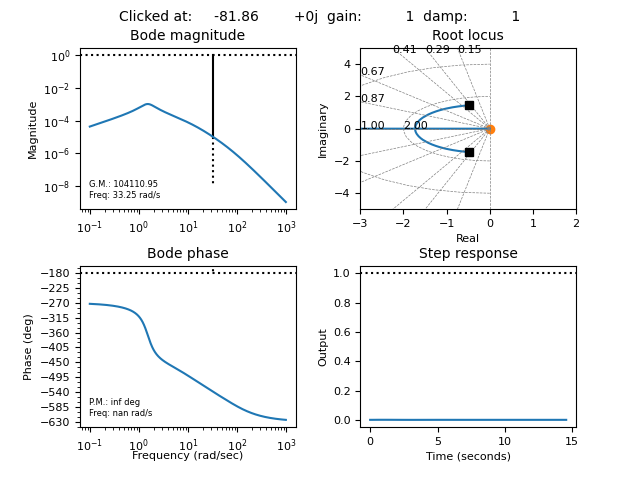

In [10]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_0, xlim_rlocus=(-3, 2), ylim_rlocus=(-5, 5),
            rlocus_grid=True)
plt.draw()  # desenhar a janela interativa

Os gráficos abaixo permitem visualizar $L(s)$ como uma função de uma variável complexa a valores complexos.

In [11]:
# Criando linhas de grade verticais no plano xy
x = np.linspace(0, 10.1, 1001)
y = np.linspace(-200, 200, 20000)

# Definindo os valores de alpha das cores das linhas de grade verticais
n = len(x)
ca = -np.log((np.linspace(1, n, n)-0.02)/n)
ca = ca/max(ca)

# Armazenando as linhas de grade verticais em listas
domain_lines = [xi + y * 1j for xi in x]

In [12]:
def plotL(K):
    # FTMA
    L = ct.tf(K * L_0)

    # Armazenando as imagens das linhas de grade verticais em listas
    image_lines = [L(line) for line in domain_lines]

    # Gráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Plotando as linhas de grade verticais no plano domínio
    for i in range(n):
        axes[0].plot(domain_lines[i].real, domain_lines[i].imag,
                    color=cp['yellow'], alpha=ca[i], linewidth=2.5)

    axes[0].plot(domain_lines[0].real, domain_lines[0].imag,
                color=cp['red'], linewidth=2.5)
    axes[0].plot([-81.8603462, -12.41365337, -0.47410221, -0.47410221], [0, 0, 1.44812641, -1.44812641], 'xk')
    axes[0].plot(4.676e-11, 0, 'ok', mfc='none')

    axes[0].set_title('Domínio')
    axes[0].set_xlabel('Re(s)')
    axes[0].set_ylabel('Im(s)')
    # axes[0].axhline(0, color='black', linewidth=0.5)
    # axes[0].axvline(0, color='black', linewidth=0.5)
    # axes[0].grid(color='gray', linestyle='--', linewidth=0.5)
    axes[0].set_xlim(-15, 10)
    axes[0].set_ylim(-10, 10)
    axes[0].set_aspect('equal', 'box')

    # Plotando a imagem das linhas de grade verticais após aplicação de L(s)
    for i in range(n):
        axes[1].plot(image_lines[i].real, image_lines[i].imag,
                    color=cp['yellow'], alpha=ca[i], linewidth=2.5)

    axes[1].plot(image_lines[0].real, image_lines[0].imag,
                color=cp['red'], linewidth=2.5)
    axes[1].plot(-1, 0, 'ok')

    axes[1].set_title('Contra-domínio')
    axes[1].set_xlabel('Re(L(s))')
    axes[1].set_ylabel('Im(L(s))')
    # axes[1].axhline(0, color='black', linewidth=0.5)
    # axes[1].axvline(0, color='black', linewidth=0.5)
    # axes[1].grid(color='gray', linestyle='--', linewidth=0.5)
    axes[1].set_xlim(-2, 2)
    axes[1].set_ylim(-2, 2)
    axes[1].set_aspect('equal', 'box')

    plt.tight_layout()
    plt.show()

Em particular, adotando $K = 30$, valor para o qual a resposta em malha fechada é estável:

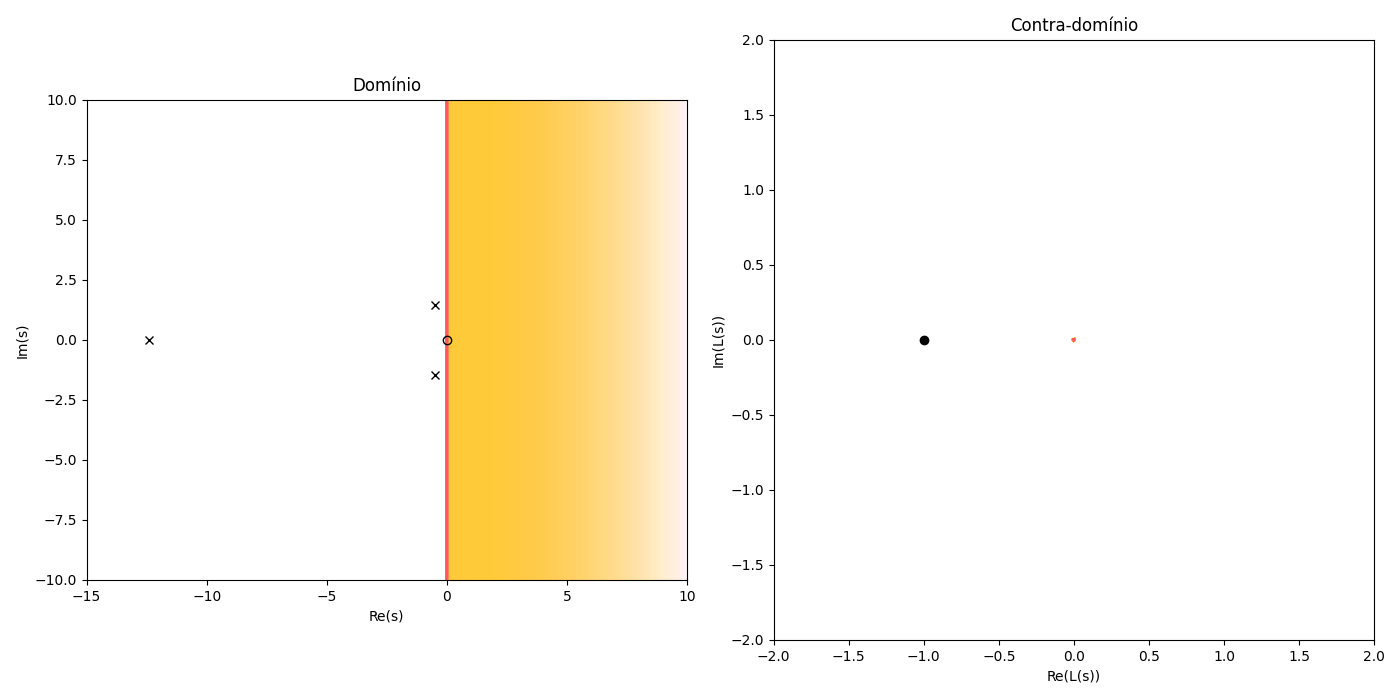

In [13]:
plotL(0.1848)

As curvas destacadas em vermelho correspondem, no domínio, ao eixo imaginário $\mathsf{j} \omega$ e, no contra-domínio, à imagem de $L(\mathsf{j} \omega)$. 

Para $K = 600$ temos claramente a garantia de estabilidade em malha fechada:

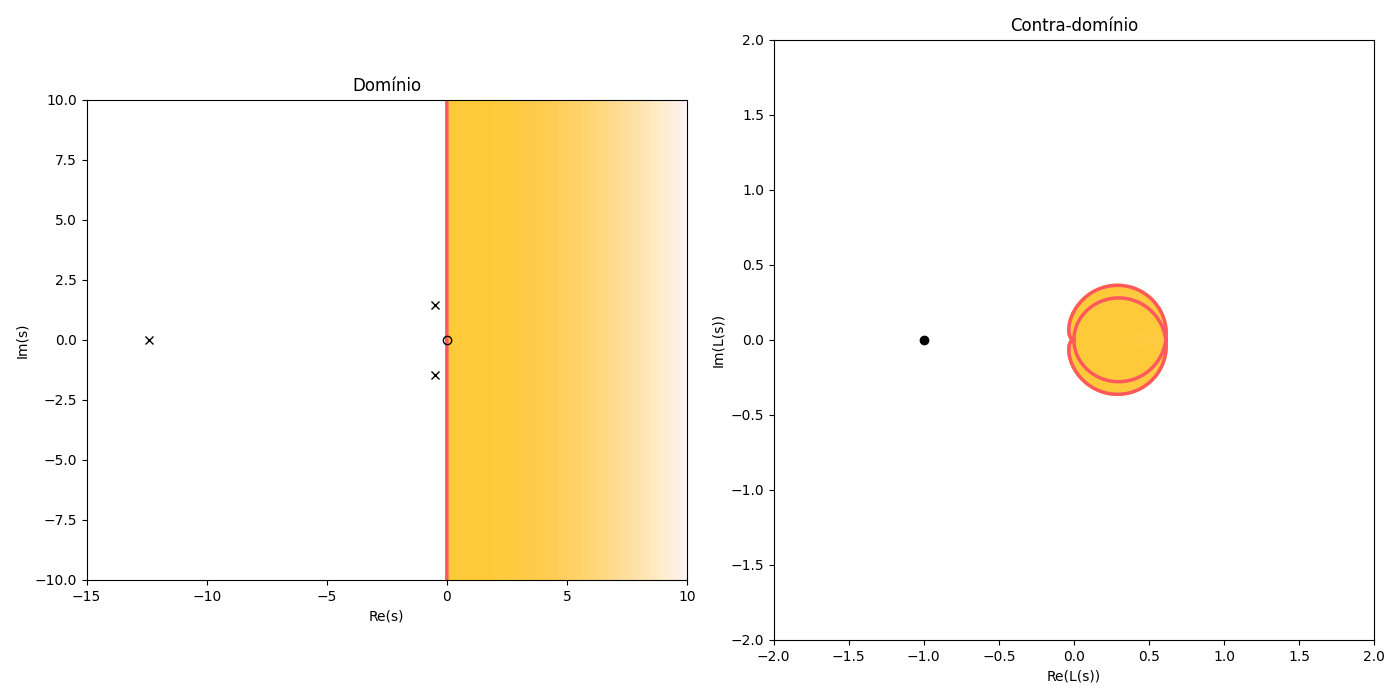

In [14]:
plotL(600)

Para $K = 105000$, também fora do intervalo que garante estabilidade em malha fechada:

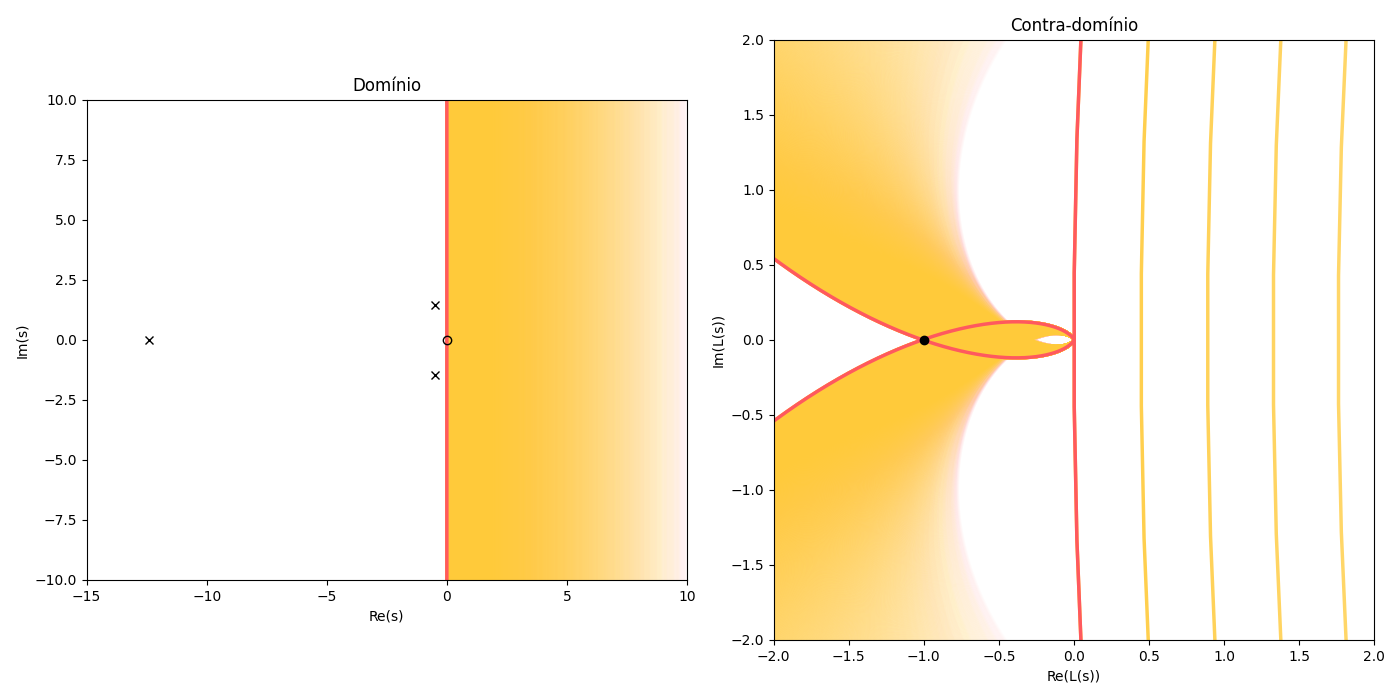

In [15]:
plotL(105000)

Em outras palavras, o sistema será **instável em malha fechada** se, e somente se, ponto $-1$ estiver contido na imagem do semi-plano complexo direito por $L(s)$, ou seja, se existir $s \in \mathbb{C}^+$ tal que $L(s) = -1$.

Considerando agora o compensador de avanço de fase anteriormente projetado para esta planta:

In [16]:
G_c_lead = ct.tf([6756, 8675], [1, 1.557])
G_c_lead

TransferFunction(array([6756, 8675]), array([1.   , 1.557]))

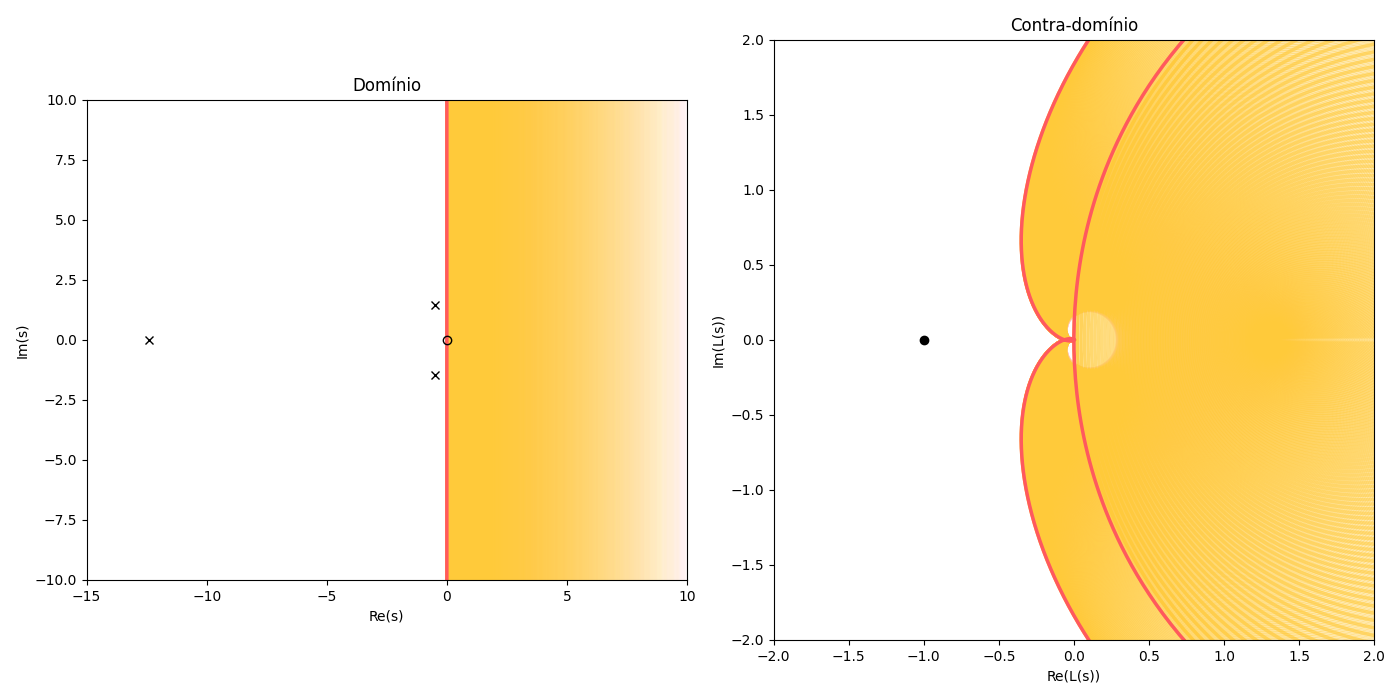

In [17]:
plotL(G_c_lead)

### 2. Diagramas de Bode e margens de estabilidade

Uma das formas que conhecemos para visualizar $L(\mathsf{j} \omega), \omega > 0$ é por meio dos *diagramas de Bode* que representam:

* $20 \log_{10}|L(\mathsf{j} \omega)|$ (em escala dB) vs. $\omega$ (em escala logaritimica)
* $\phase{L(\mathsf{j} \omega)}$ (em graus) vs. $\omega$ (em escala logaritimica)

Para a função do exemplo, considerando $K = 0.1848$:

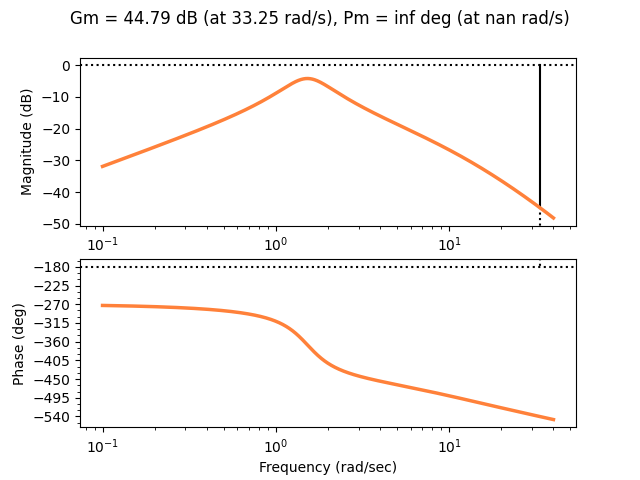

In [21]:
plt.figure()
L30_m, L30_φ, L30_ω = ct.bode_plot(
    600 * L_0, color=cp['orange'], linewidth=2.5, dB=True, margins=True, omega_limits=(1e-1, 40), initial_phase=-270)

Considerando agora a presença do compensador de avanço de fase projetado para esta planta:

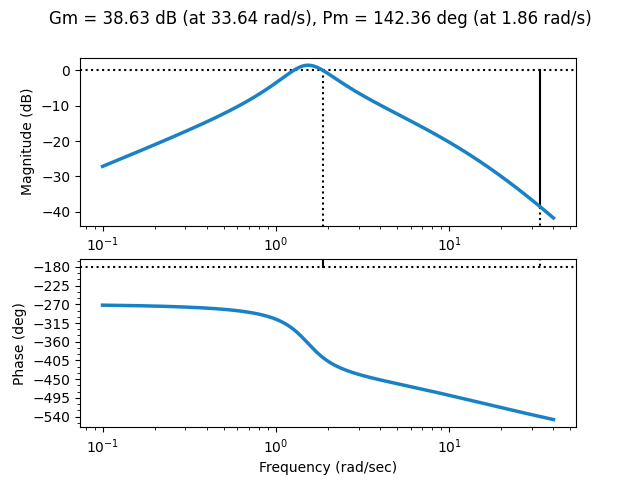

In [32]:
plt.figure()
Lc_m, Lc_φ, Lc_ω = ct.bode_plot(
    (G_c_lead*0.1848)* L_0, color=cp['blue'], linewidth=2.5, dB=True, margins=True, omega_limits=(1e-1, 40), initial_phase=-270)

Se estivessemos em uma situação de **ganho crítico**, o sistema teria polos sobre o eixo imaginário, ou seja, *para algum $\omega > 0$*:
$$
L(\mathsf{j} \omega) = -1 
\quad \Rightarrow \quad 
20 \log_{10} |L(\mathsf{j} \omega)| = 0
\quad \text{e} \quad
\phase{L(\mathsf{j} \omega)} \equiv 180^\circ
$$
Em outras palavras, para algum valor de $\omega$ deveríamos ter **simultaneamente** o gráfico de magnitude cruzando o limiar de 0 dB e o gráfico de fase cruzando o limiar de $- 180^\circ$.

Nos exemplos mostrados, seja adotando um ganho proporcional $K = 30$ ou o compensador PID, a resposta do sistema em malha fechada é estável, o que nos permite identificar:
* $\omega_\phi$: frequência de ganho crítico (*gain crossover*), para a qual $20 \log_{10} |L(\mathsf{j} \omega_\phi)| = 0 \ \text{dB}$ ;
* $\omega_c$: frequência de fase crítica (*phase crossover*), para a qual $\phase{L(\mathsf{j} \omega_c)} = -180^\circ$.

Estaremos em uma situação de ganho crítico, portanto, se $\omega_\phi = \omega_c$. Caso contrário, dispomos de **margens de estabilidade** para *variação de ganho* ou *atrasos em fase* sem que a estabilidade nominal do sistema esteja comprometida. Definimos assim as margens de ganho e fase:

* **Margem de ganho (GM)**:
$$
\text{GM} = \frac{1}{|L(\mathsf{j} \omega_c)|}
\qquad \text{ou} \qquad 
\text{GM(dB)} = - 20 \log_{10} |L(\mathsf{j} \omega_c)|
$$
* **Margem de fase (PM)**:
$$
\text{PM} = 180^\circ + \phase{L(\mathsf{j} \omega_\phi)}
\qquad \text{com} \qquad
\phase{L(\mathsf{j} \omega_\phi)} < 0
$$


Outra forma forma de avaliar a estabilidade é por meio da resposta em frequência da **função de sensibilidade**:
$$
S(\mathsf{j} \omega) = \frac{1}{1 + L(\mathsf{j} \omega)}
$$
Em particular, o valor de $\omega = \omega_s$ para o qual $|S(\mathsf{j} \omega)|$ é máximo, corresponde ao ponto do eixo imaginário cuja imagem por $L(s)$ está o mais próximo possível do ponto crítico $-1$, uma vez que o valor $|1 + L(\mathsf{j} \omega_s)|$ será mínimo.

Usando a função `stability_margins` podemos verificar as margens de estabilidade quando adotamos um ganho proporcional $K = 600$:

In [22]:
L30_margins = ct.stability_margins(600 * L_0)  
L30_margins  # GM, PM, 1/|S(ω_s)|, ω_c, ω_φ, ω_s

(173.51824426217584,
 inf,
 0.9683760268461072,
 33.2530461757149,
 nan,
 7.733481036999404)

In [23]:
20 * np.log10(L30_margins[0])  # GM(dB)

44.786902892719965

In [24]:
- 20 * np.log10(L30_margins[2])  # S(ω_s)(dB)

0.27911941016001895

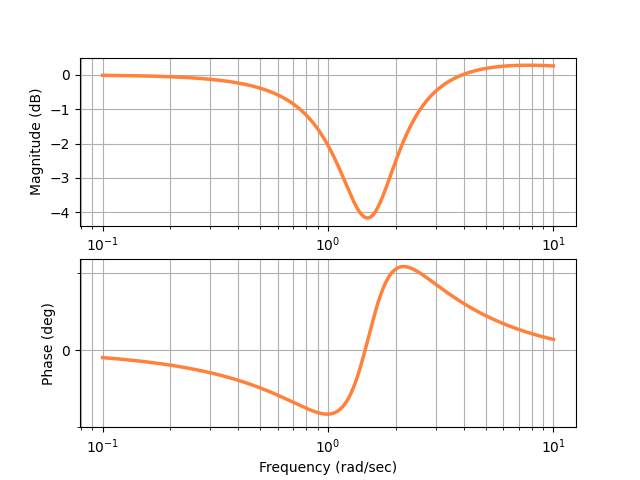

In [34]:
# Diagrama de Bode para função de sensibilidade
plt.figure()
_, _, _ = ct.bode_plot(
    1/(1 + 600 * L_0), color=cp['orange'], linewidth=2.5, dB=True, omega_limits=(1e-1, 10))

Analogamente, para o caso em que se considera o compensador PID:

In [26]:
Lc_margins = ct.stability_margins(G_c_lead * L_0)  
Lc_margins  # GM, PM, 1/|S(ω_s)|, ω_c, ω_φ, ω_s

(15.77841983273985,
 70.91603147340274,
 0.7621538633219819,
 33.637396746117055,
 6.177206973627327,
 12.084872160334898)

In [27]:
20 * np.log10(Lc_margins[0])  # GM(dB)

23.96127015201317

In [28]:
- 20 * np.log10(Lc_margins[2])  # S(ω_s)(dB)

2.3591468922040164

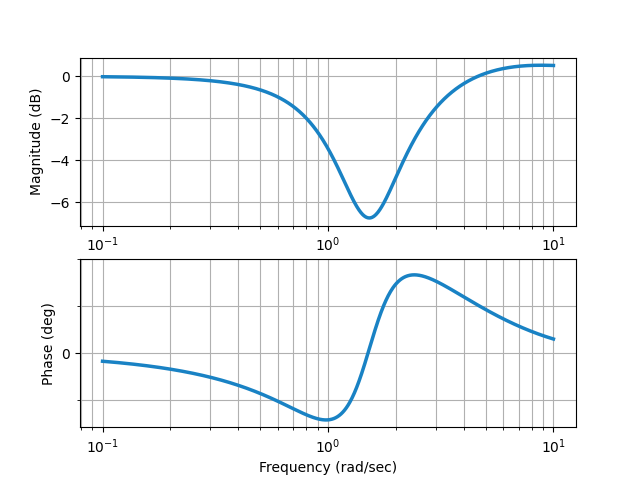

In [35]:
# Diagrama de Bode para função de sensibilidade
plt.figure()
_, _, _ = ct.bode_plot(
    1/(1 + G_c_lead * 0.1848* L_0), color=cp['blue'], linewidth=2.5, dB=True, omega_limits=(1e-1, 10))